<a href="https://colab.research.google.com/github/abbyDC/speech-recog-ml-task/blob/main/kws_eval_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keyword Spotting: Evaluation and Inference

This notebook allows you to evaluate on the full test dataset and inferencing on an uploaded audio file.


## Setup

Import necessary modules and dependencies.
Part of this setup downloads the raw test set, preprocessed test set and trained model.
It will save it in the '/content/' drive.

### Download the preprocessed test set

In [ ]:
import gdown

#import prerprocessed test set audio
url = "https://drive.google.com/uc?export=download&id=1-3hRuKgkn4yIl6I-7Y5et18oSCD_QqkW"
output = "/content/speech_commands_test_audio.pkl"
gdown.download(url, output,quiet=False)

#import prerprocessed test set labels
url = "https://drive.google.com/uc?export=download&id=1-661Fi2WKE9doWO2MmYNH3XCSb2I2bny"
output = "/content/speech_commands_test_labels.pkl"
gdown.download(url, output,quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1-3hRuKgkn4yIl6I-7Y5et18oSCD_QqkW
To: /content/speech_commands_test_audio.pkl
100%|██████████| 313M/313M [00:03<00:00, 81.6MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-661Fi2WKE9doWO2MmYNH3XCSb2I2bny
To: /content/speech_commands_test_labels.pkl
100%|██████████| 39.3k/39.3k [00:00<00:00, 16.5MB/s]


'/content/speech_commands_test_labels.pkl'

### Download the best trained model

In [ ]:
url = "https://drive.google.com/uc?export=download&id=191jesT14Tt_3heCOd_OjOQ7RG9msOH5L"
output = "/content/cnn_keras_model.zip"
gdown.download(url, output,quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=191jesT14Tt_3heCOd_OjOQ7RG9msOH5L
To: /content/cnn_keras_model.zip
100%|██████████| 16.5M/16.5M [00:00<00:00, 178MB/s]


'/content/cnn_keras_model.zip'

In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/cnn_keras_model.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('/content/')
    print('Done!')

File Name                                             Modified             Size
cnn_keras_model/3/keras_metadata.pb            2021-11-21 18:59:58        17202
cnn_keras_model/3/saved_model.pb               2021-11-21 18:59:58       164016
cnn_keras_model/3/assets/                      2021-11-21 23:33:54            0
cnn_keras_model/3/variables/variables.index    2021-11-21 18:59:58         2501
cnn_keras_model/3/variables/variables.data-00000-of-00001 2021-11-21 18:59:58     19521777
Extracting all the files now...
Done!


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import pickle

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import Full Test Data

This loads the full test data given a path.

In [ ]:
TEST_DATASET_PATH = '/content/speech_commands_test_set_v0.02'

test_data_dir = pathlib.Path(TEST_DATASET_PATH)
if not test_data_dir.exists():
  url = "https://drive.google.com/uc?export=download&id=1cFzDj_fiWIsg234SMVFir4EKvTsbcgeI"
  output = "/content/speech_commands_test_set_v0.02.zip"
  gdown.download(url, output,quiet=False)

  # unzip files
  from zipfile import ZipFile
  file_name = "/content/speech_commands_test_set_v0.02.zip"
    
  with ZipFile(file_name, 'r') as zip:
      # zip.printdir()
      print('Extracting all the files now...')
      zip.extractall('/content/')
      print('Done!')

12 keywords were used in the test set namely: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`, `off`, `on`, `_silence_`, `_unknown_`:

In [ ]:
# commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
# commands = commands[commands != 'README.md']
commands = np.array(['no', '_silence_','left','go','stop','off','down','on','right','yes',
 '_unknown_','up'])

In [ ]:
#TEST
test_filenames = tf.io.gfile.glob(str(test_data_dir) + '/*/*')
test_filenames = tf.random.shuffle(test_filenames)
test_num_samples = len(test_filenames)
print('Number of total examples:', test_num_samples)

Number of total examples: 4890


In [ ]:
for x in range(0,12):
  print('Number of examples per label:',
        len(tf.io.gfile.listdir(str(test_data_dir/commands[x]))))
print('Example file tensor:', test_filenames[0])

Number of examples per label: 405
Number of examples per label: 412
Number of examples per label: 425
Number of examples per label: 396
Number of examples per label: 408
Number of examples per label: 402
Number of examples per label: 408
Number of examples per label: 411
Number of examples per label: 402
Number of examples per label: 419
Number of examples per label: 406
Number of examples per label: 396
Example file tensor: tf.Tensor(b'/content/speech_commands_test_set_v0.02/on/a60a09cf_nohash_1.wav', shape=(), dtype=string)


In [ ]:
test_files = test_filenames

print('Test set size', len(test_files))

Test set size 4890


## Data Preprocessing

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

### Convert waveforms to spectrograms

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### Get the correspong labels as integer IDs

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

## Evalaution on Test Set
Run the model on the test set and check the model's performance:

### Load Trained Model

In [ ]:
model_path = "/content/cnn_keras_model/3"
model = tf.keras.models.load_model(model_path)

### Load the pickled and preprocessed test set

In [ ]:
# load preprocessed test set (4890 tests)
with open('/content/speech_commands_test_audio.pkl','rb') as f: test_audio = pickle.load(f)
with open('/content/speech_commands_test_labels.pkl','rb') as f: test_labels = pickle.load(f)

In [ ]:
print("# of test audio:",len(test_audio))
print("# of test labels:",len(test_labels))

# of test audio: 4890
# of test labels: 4890


### **Uncomment this if you want to preprocess a new batch of test data

In [ ]:
# test_ds = preprocess_dataset(test_files)

# test_audio = []
# test_labels = []

# for audio, label in test_ds:
#   test_audio.append(audio.numpy())
#   test_labels.append(label.numpy())

# test_audio = np.array(test_audio)
# test_labels = np.array(test_labels)

### Display the test set accuracy

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.2%}')

Test set accuracy: 91.60%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


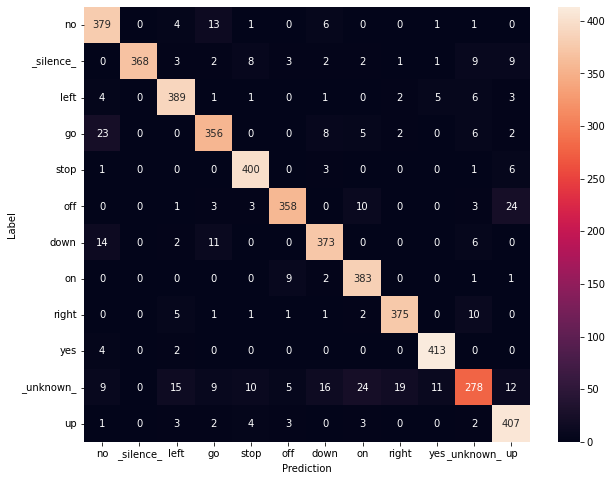

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferencing on an audio file

Upload a wav file to test the model's predictions. You can use any file from the downloaded "speech_commands_test_set_v0.02" by just specifying the filename.

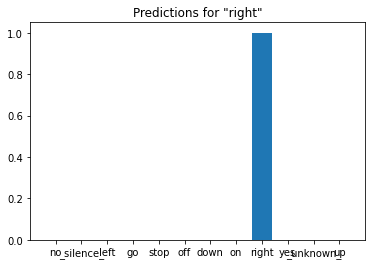

In [ ]:
commands = np.array(['no', '_silence_','left','go','stop','off','down','on','right','yes',
 '_unknown_','up'])

sample_file = test_data_dir/'right/18f8afd5_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()